In [2]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_points import *
from read_positions import read_positions
from perspective import *
import random
%matplotlib inline
import random
from helper import *



In [3]:
df = read_positions(label_dir='../../data/labels', output_csv='positions.csv')
# df = df[(df['Camera'] == 1) | (df['Camera'] == 2) | (df['Camera'] == 4)]
df.head(11)
len(df)

2867

In [4]:
ELEPHANT_SIZE = 2.5
IMG_WIDTH, IMG_HEIGHT = 1920, 1000

MAP_WIDTH_12, MAP_HEIGHT_12 = 846, 572
MAP_REAL_WIDTH_12 = 10

MAP_WIDTH_6, MAP_HEIGHT_6 = 890, 573
MAP_REAL_WIDTH_6 = 60

MAP_WIDTH_4, MAP_HEIGHT_4 = 730, 488
MAP_REAL_WIDTH_4 = 45

MAP_WIDTH_7, MAP_HEIGHT_7 = 608, 572
MAP_REAL_WIDTH_7 = 9

IMAGE_PTS_1 = np.array([[342, 272], [1346, 120], [1320, 396], [598, 410]])
MAP_PTS_1 = np.array([[169, 555],  [20, 243], [281, 292], [282, 458]])
H1, _ = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)

IMAGE_PTS_2 = np.array([[35, 447], [1050, 299], [912, 405], [281, 513]])
MAP_PTS_2 = np.array([[685, 242],  [678, 552], [599, 463], [599, 291]])
H2, _ = cv2.findHomography(IMAGE_PTS_2, MAP_PTS_2)

IMAGE_PTS_4 = np.array([[748, 340],[1711, 375], [1778, 148],[1044, 91],  [430, 55],[175, 151]])
MAP_PTS_4 = np.array([ [456, 411], [619, 411], [700, 174], [470, 170], [147, 43], [43, 128]])
H4, _ = cv2.findHomography(IMAGE_PTS_4, MAP_PTS_4)

IMAGE_PTS_6 = np.array([[1394, 416], [1158, 326], [248, 428], [600, 342]])
MAP_PTS_6 = np.array([[563, 62], [360, 32], [363, 391], [95, 263]])
H6, _ = cv2.findHomography(IMAGE_PTS_6, MAP_PTS_6)

IMAGE_PTS_7 = np.array([[711, 544],[1353, 564], [1651, 402],[633, 187]])
MAP_PTS_7 = np.array([ [347, 331], [348, 462], [444, 556], [598, 286]])
H7, _ = cv2.findHomography(IMAGE_PTS_7, MAP_PTS_7)

CAMERA_to_H = {
    1: H1,
    2: H2,
    4: H4,
    6: H6,
    7: H7
}

CAMERA_to_MAP = {
    1: (MAP_WIDTH_12, MAP_HEIGHT_12),
    2: (MAP_WIDTH_12, MAP_HEIGHT_12),
    4: (MAP_WIDTH_4, MAP_HEIGHT_4),
    6: (MAP_WIDTH_6, MAP_HEIGHT_6),
    7: (MAP_WIDTH_7, MAP_HEIGHT_7)
}

CAMERA_to_REAL = {
    1: MAP_REAL_WIDTH_12,
    2: MAP_REAL_WIDTH_12,
    4: MAP_REAL_WIDTH_4,
    6: MAP_REAL_WIDTH_6,
    7: MAP_REAL_WIDTH_7
}

def shift(x, y, width, height, camera):
    if camera in [1, 2, 4, 6, 7]:
        y += height/3
    else:
        y += height/2
    return x, y, width, height

In [5]:
# H, mask = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)

df_proj = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Width', 'Height'])
for index, row in df.iterrows():
    data = {}
    data['Camera'] = row['Camera']
    map_width, map_height = CAMERA_to_MAP[data['Camera']]
    H = CAMERA_to_H[data['Camera']]
    width_real = CAMERA_to_REAL[data['Camera']]
    # print(width_real)
    data['Date'] = row['Date']
    x, y, width, height = row['X_center'], row['Y_center'], row['Width'], row['Height']
    
    x, y = x*IMG_WIDTH, y*IMG_HEIGHT
    width, height = width*IMG_WIDTH, height*IMG_HEIGHT
    # print(f'x, y, w, h = {x, y, width, height}')
    x, y, width, height = shift(x, y, width, height, data['Camera'])
        
    x_proj, y_proj = transform_row(H, x, y)
    # print(polygon)  
    data['X_center'], data['Y_center'] = x_proj/map_width, y_proj/map_height
    data['Width'], data['Height'] = get_size(map_width, map_height, width_real)
    
    # if data['Camera'] == 2 and random.random() > 0.35:
    #     continue
    df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)
print(f'LEN = {len(df_proj)}')
df_proj.head()

/tmp/ipykernel_2234947/4030764901.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)


LEN = 2867


,Camera,Date,X_center,Y_center,Width,Height
0,2,2024-01-25 17:30:00,0.515882,0.857321,0.250000,0.369755
1,2,2024-01-25 17:30:00,0.422118,0.901539,0.250000,0.369755
2,7,2024-01-30 20:30:00,0.391419,0.741827,0.277778,0.295260
3,2,2024-01-29 16:30:00,0.462926,0.901225,0.250000,0.369755
4,2,2024-01-29 16:30:00,0.564416,0.867610,0.250000,0.369755


In [6]:
df_proj['Camera'].value_counts()

Camera
2    1122
7     867
1     393
6     278
4     207
Name: count, dtype: int64

In [7]:
def remove_duplicate_elephants(df, threshold=0.07):

    def calculate_distance(row1, row2):
        """Calculate the Euclidean distance between two points."""
        return np.linalg.norm(np.array([row1['X_center'], row1['Y_center']]) - np.array([row2['X_center'], row2['Y_center']]))

    
    # Prepare a list to track indices to remove
    indices_to_remove = []

    # Iterate through each unique timestamp
    for timestamp in df['Date'].unique():
        # Filter entries for this specific timestamp for both cameras
        cam1_entries = df[(df['Camera'] == 1) & (df['Date'] == timestamp)]
        cam2_entries = df[(df['Camera'] == 2) & (df['Date'] == timestamp)]
        
        # Nested loop to calculate distances between all cam1 and cam2 entries
        for index1, row1 in cam1_entries.iterrows():
            for index2, row2 in cam2_entries.iterrows():
                distance = calculate_distance(row1, row2)
                
                # If distance is within threshold, check mutual closeness
                if distance < threshold:
                    # Find closest cam2 entry to current cam1 entry
                    
                    closest_to_cam1 = cam2_entries.apply(lambda row: calculate_distance(row, row1), axis=1).idxmin()
                    # Find closest cam1 entry to current cam2 entry
                    closest_to_cam2 = cam1_entries.apply(lambda row: calculate_distance(row, row2), axis=1).idxmin()
                    # Check mutual closeness
                    if closest_to_cam1 == index2 and closest_to_cam2 == index1:
                        assert index2 not in indices_to_remove
                        indices_to_remove.append(index2)  # Add cam2 entry to removal list
                        c1 = (row1['X_center'], row1['Y_center'])
                        c2 = (row2['X_center'], row2['Y_center'])
                        # print(distance)
                        c1 = (c1[0]*MAP_WIDTH_12, c1[1]*MAP_HEIGHT_12)
                        c2 = (c2[0]*MAP_WIDTH_12, c2[1]*MAP_HEIGHT_12)


    # Drop the entries from the original DataFrame
    df_cleaned = df.drop(indices_to_remove)
    
    return df_cleaned
    
df_proj = remove_duplicate_elephants(df_proj)
df_proj['Camera'].value_counts()


Camera
2    963
7    867
1    393
6    278
4    207
Name: count, dtype: int64

In [8]:
def balance_camera_entries(df):
    # Count the number of entries for each camera
    cam1_count = df[df['Camera'] == 1].shape[0]
    cam2_count = df[df['Camera'] == 2].shape[0]
    
    # Determine which camera has more entries and compute the difference
    if cam1_count > cam2_count:
        more_entries_camera = 1
        entries_to_remove = cam1_count - cam2_count
    elif cam2_count > cam1_count:
        more_entries_camera = 2
        entries_to_remove = cam2_count - cam1_count
    else:
        # The dataset is already balanced
        print("The dataset is already balanced.")
        return df

    # Randomly select indices of the camera with more entries to be deleted
    indices_to_remove = np.random.choice(df[df['Camera'] == more_entries_camera].index, entries_to_remove, replace=False)
    
    # Remove the selected indices
    df_balanced = df.drop(indices_to_remove)
    
    return df_balanced

# Example usage
df_proj = balance_camera_entries(df_proj)
df_proj['Camera'].value_counts()

Camera
7    867
2    393
1    393
6    278
4    207
Name: count, dtype: int64

In [18]:
def get_heatmap_new(df, camera, size):
    df = df[df['Camera'].isin(camera)]
    # print(df['Camera'])

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = size

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap):
        # Calculate the bounding box in pixel coordinates
        left = int(max(0, cx - w/2))
        right = int(min(heatmap_width, cx + w/2))
        top = int(max(0, cy - h/2))
        bottom = int(min(heatmap_height, cy + h/2))

        sigma_x = 20
        sigma_y = 20
        # print(sigma_x, sigma_y)

        # Apply intensity only within the bounding box, using a Gaussian distribution
        for y in range(top, bottom):
            for x in range(left, right):
                dx = cx - x
                dy = cy - y
                value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                heatmap[y, x] += 10*value

    # Populate the heatmap with bounded Gaussian distribution
    for index, row in df.iterrows():
        cx, cy, w, h = row['X_center'] * heatmap_width, row['Y_center'] * heatmap_height, row['Width'] * heatmap_width, row['Height'] * heatmap_height
        apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap_img)

    # print(np.max(heatmap_img))
    # # Normalize the heatmap
    # cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    # zero_mask = (heatmap_img < 20)
    # # Apply a colormap to create a color heatmap
    # heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    # heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_img


In [10]:
# # Optionally, load an actual image to overlay the heatmap on
# original_img = cv2.imread('maps/map12.png')
# heatmap_color = get_heatmap_new(df_proj[:1], [1, 2], CAMERA_to_MAP[1])
# overlayed_img1 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
# plt.figure()
# plt.imshow(overlayed_img1[..., ::-1])  # change channels order since the YOLO work on BGR images
# plt.show()


In [11]:
# # Optionally, load an actual image to overlay the heatmap on
# original_img = cv2.imread('maps/map6_real.png')
# heatmap_color = get_heatmap_new(df_proj[16:17], [6], CAMERA_to_MAP[6])
# overlayed_img6 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
# plt.figure()
# plt.imshow(overlayed_img6[..., ::-1])  # change channels order since the YOLO work on BGR images
# plt.show()


In [12]:
# # Optionally, load an actual image to overlay the heatmap on
# original_img = cv2.imread('maps/map4_real.png')
# heatmap_color = get_heatmap_new(df_proj[19:20], [4], CAMERA_to_MAP[4])
# overlayed_img4 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
# plt.figure()
# plt.imshow(overlayed_img4[..., ::-1])  # change channels order since the YOLO work on BGR images
# plt.show()


In [13]:
# # Optionally, load an actual image to overlay the heatmap on
# original_img = cv2.imread('maps/map7.png')
# heatmap_color = get_heatmap_new(df_proj[2:3], [7], CAMERA_to_MAP[7])
# overlayed_img7 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
# plt.figure()
# plt.imshow(overlayed_img7[..., ::-1])  # change channels order since the YOLO work on BGR images
# plt.show()


In [14]:

# def create_layout(overlayed_img1, overlayed_img4 , overlayed_img6, overlayed_img7):
#     top_part = np.hstack((overlayed_img7, overlayed_img1))
    
#     # Resizing overlayed_img6 to have a height of 488 while maintaining aspect ratio
#     original_height6, original_width6 = overlayed_img6.shape[:2]
#     new_height6 = overlayed_img4.shape[0]
#     aspect_ratio6 = original_width6 / original_height6
#     new_width6 = int(new_height6 * aspect_ratio6)
#     overlayed_img6_resized = cv2.resize(overlayed_img6, (new_width6, new_height6))
    
#     # Create a vertical separator with a black outline and a grey center
#     separator_line_width = 20
#     vertical_separator_outline = np.zeros((overlayed_img4.shape[0], separator_line_width, 3), dtype=np.uint8) # Black outline
#     outline_thickness = 2  # Thickness of the black outline
#     cv2.rectangle(vertical_separator_outline, (0, 0), (separator_line_width, vertical_separator_outline.shape[0]), (128, 128, 128), thickness=-1)  # Fill with grey
#     cv2.rectangle(vertical_separator_outline, (0, 0), (separator_line_width-1, vertical_separator_outline.shape[0]-1), (0, 0, 0), thickness=outline_thickness)  # Black outline
    
#     # Concatenate images 4 and 6 horizontally with the outlined vertical separator
#     bottom_part = np.hstack((overlayed_img4, vertical_separator_outline, overlayed_img6_resized))
#     final_width = bottom_part.shape[1]
    
#     # Rescale the top part to match the width of the bottom part
#     aspect_ratio_top = top_part.shape[0] / top_part.shape[1]
#     new_height_top = int(final_width * aspect_ratio_top)
#     top_part_rescaled = cv2.resize(top_part, (final_width, new_height_top))
    
#     # Create a horizontal separator with a black outline and a grey center
#     separator_height = 20
#     horizontal_separator_outline = np.zeros((separator_height, final_width, 3), dtype=np.uint8)  # Black outline
#     cv2.rectangle(horizontal_separator_outline, (0, 0), (final_width, separator_height), (128, 128, 128), thickness=-1)  # Fill with grey
#     cv2.rectangle(horizontal_separator_outline, (0, 0), (final_width-1, separator_height-1), (0, 0, 0), thickness=outline_thickness)  # Black outline
    
#     # Vertically stack the rescaled top part, the outlined horizontal separator, and the bottom part
#     final_layout = np.vstack((top_part_rescaled, horizontal_separator_outline, bottom_part))
#     return final_layout


In [15]:
# x = create_layout(overlayed_img1, overlayed_img4 , overlayed_img6, overlayed_img7)
# plot_images(x)

In [19]:
camera_ids = [2, 4, 6, 7]  # Example camera IDs

raw_heatmaps = [get_heatmap_new(df_proj, [camera], CAMERA_to_MAP[camera]) for camera in camera_ids]
global_max = np.max([np.max(heatmap) for heatmap in raw_heatmaps])


In [57]:
def normalize_and_apply_colormap(heatmap, global_max):
    # Scale heatmap values based on global_max directly
    heatmap_scaled = (heatmap / global_max) * 255 * 2
    heatmap_scaled = np.clip(heatmap_scaled, 0, 255).astype(np.uint8)  # Ensure values are within byte range
    zero_mask = (heatmap_scaled < 10)
    
    # Apply a colormap to the scaled heatmap
    heatmap_color = cv2.applyColorMap(heatmap_scaled, cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    return heatmap_color

# Assuming heatmaps is a list of raw heatmap arrays and global_max is the maximum value across all these arrays
normalized_heatmaps = [normalize_and_apply_colormap(heatmap, global_max) for heatmap in raw_heatmaps]


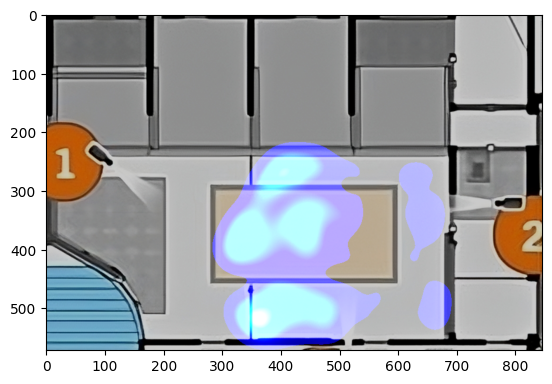

In [58]:
# # Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('maps/map12.png')
heatmap_color = normalized_heatmaps[0]
overlayed_img1 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img1[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


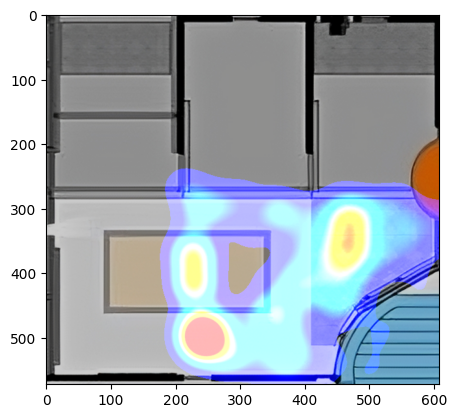

In [59]:
# # Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('maps/map7.png')
heatmap_color = normalized_heatmaps[3]
overlayed_img1 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img1[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


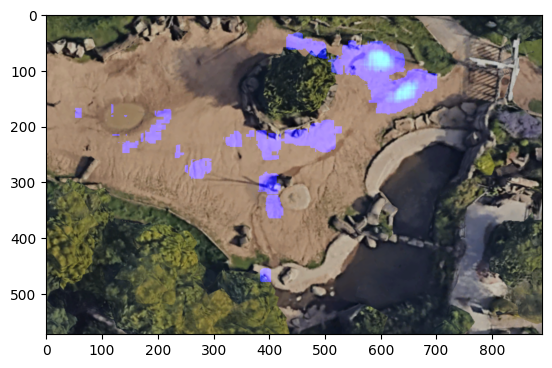

In [60]:
# # Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('maps/map6_real.png')
heatmap_color = normalized_heatmaps[2]
overlayed_img1 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img1[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


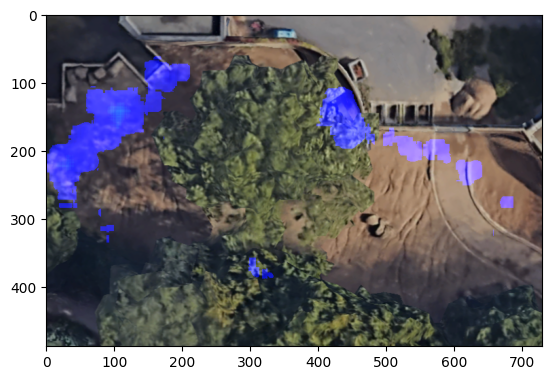

In [61]:
# # Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('maps/map4_real.png')
heatmap_color = normalized_heatmaps[1]
overlayed_img1 = cv2.addWeighted(original_img, 0.8, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img1[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()
